## 16. 행동 스티커 만들기

### [ 목  차 ]
1. 데이터 전처리하기
2. TFRecord 파일 만들기
3. Ray
4. data label 로 만들기
5. 모델 학습
  * Hourglass 모델링
6. 학습 엔진 만들기
7. 예측 엔진 만들기
8. Project: 모델 바꿔보기
  * Simplebaseline 모델링
9. 결론

[ 회 고 ]

### 1. 데이터 전처리하기

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

슝=3


In [2]:
# json 파싱하기
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [3]:
# json annotation 을 파싱하는 함수
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [4]:
# parse_one_annotation()함수를 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


### 2. TFRecord 파일 만들기

In [5]:
# 하나의 annotation을 하나의 tf.train.Example로 만들어 주는 함수
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [6]:
# 얼마나 많은 TFRecord를 만들지 결정할 함수
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


In [7]:
# chunkify함수 테스트
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
# 하나의 chunk를 TFRecord로 만들어 줄 함수
# Ray는 병렬 처리를 위한 라이브러리인데요. 파이썬에서 기본적으로 제공하는 multiprocessing 패키지보다 편하게 다양한 환경에서 사용
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


In [9]:
# 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


### 3. Ray

In [10]:
# 작성한 함수를 사용해 데이터를 TFRecord로 작성
# train 데이터는 64개로, val 데이터는 8개의 파일로
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2022-08-10 23:05:50,920	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.85gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=188) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=188) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=189) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=189) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=187) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=187) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=188) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=188) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=189) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=189) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=188) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=188) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=187) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=187) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=189) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=189) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

### 4. data label 로 만들기

In [11]:
# TFRecord로 저장된 데이터를 모델에 학습에 필요한 데이터로 바꿔줄 함수
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

슝=3


In [12]:
# 이미지를 그대로 사용하지 않고 적당히 정사각형으로 crop하여 사용
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

슝=3


In [13]:
# (x, y) 좌표로 되어있는 keypoint 를 heatmap 으로 변경
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


In [14]:
# 지금까지 만든 함수들을 객체(class) 형태로 조합
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


### 5. 모델 학습

#### Hourglass 모델 만들기

In [16]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [17]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [18]:
# intermediate output을 위한 linear layer
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


In [19]:
# stacked hourglass
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


### 6. 학습 엔진 만들기
GPU가 여러 개인 환경:     
가장 핵심 키워드는 tf.distribute.MirroredStrategy입니다. 한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법인데요. 여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합합니다. 그런 후 모델의 가중치를 업데이트 하도록 하는 것이죠.    
각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할은 strategy.reduce 함수가 담당합니다

In [20]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model_HG-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


In [29]:
# 데이터셋을 만드는 함수
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


In [22]:
# 데이터셋과 모델, 훈련용 객체를 조립하는 함수
# 주의할 점은 with strategy.scope():부분이 반드시 필요
# 또 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다는 것도 중요

def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

슝=3
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/tas

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.63002634 epoch total loss 2.63002634
Trained batch 2 batch loss 2.37071157 epoch total loss 2.50036907
Trained batch 3 batch loss 2.54354453 epoch total loss 2.51476097
Trained batch 4 batch loss 2.12307787 epoch total loss 2.41684
Trained batch 5 batch loss 2.12745762 epoch total loss 2.35896349
Trained batch 6 batch loss 2.10977554 epoch total loss 2.31743217
Trained batch 7 batch loss 2.07241297 epoch total loss 2.28242946
Trained batch 8 batch loss 2.1175077 epoch total loss 2.26181436
Trained batch 9 batch loss 2.12731934 epoch total loss 2.24687052
Trained batch 10 batch loss 1.81066942 epoch total loss 2.20325041
Trained batch 11 batch loss 1.99760377 epoch total loss 2.18455529
Trained batch 12 batch loss 1.97001588 epoch total loss 2.166677
Trained batch 13 batch loss 1.66800332 epoch total loss 2.12831736
Trained batch 14 batch loss 1.97750592 epoch total loss 2.11754537
Trained batch 15 batch loss 2.03217268 epoch t

Trained batch 124 batch loss 1.69745803 epoch total loss 1.78710818
Trained batch 125 batch loss 1.74132276 epoch total loss 1.78674185
Trained batch 126 batch loss 1.68301725 epoch total loss 1.78591859
Trained batch 127 batch loss 1.57026649 epoch total loss 1.78422058
Trained batch 128 batch loss 1.5964663 epoch total loss 1.78275371
Trained batch 129 batch loss 1.57566595 epoch total loss 1.78114843
Trained batch 130 batch loss 1.65486991 epoch total loss 1.78017712
Trained batch 131 batch loss 1.73217583 epoch total loss 1.77981067
Trained batch 132 batch loss 1.65057862 epoch total loss 1.7788316
Trained batch 133 batch loss 1.57329106 epoch total loss 1.77728617
Trained batch 134 batch loss 1.53051615 epoch total loss 1.77544463
Trained batch 135 batch loss 1.55718374 epoch total loss 1.77382791
Trained batch 136 batch loss 1.66388583 epoch total loss 1.77301943
Trained batch 137 batch loss 1.49610829 epoch total loss 1.77099824
Trained batch 138 batch loss 1.46602595 epoch tota

Trained batch 245 batch loss 1.55842018 epoch total loss 1.69937158
Trained batch 246 batch loss 1.50383091 epoch total loss 1.69857681
Trained batch 247 batch loss 1.57374358 epoch total loss 1.69807136
Trained batch 248 batch loss 1.59529209 epoch total loss 1.69765699
Trained batch 249 batch loss 1.66137755 epoch total loss 1.6975112
Trained batch 250 batch loss 1.65132606 epoch total loss 1.69732654
Trained batch 251 batch loss 1.55854201 epoch total loss 1.69677353
Trained batch 252 batch loss 1.57918239 epoch total loss 1.69630694
Trained batch 253 batch loss 1.62283611 epoch total loss 1.69601655
Trained batch 254 batch loss 1.63655233 epoch total loss 1.69578254
Trained batch 255 batch loss 1.64171112 epoch total loss 1.69557047
Trained batch 256 batch loss 1.62187278 epoch total loss 1.6952827
Trained batch 257 batch loss 1.61438084 epoch total loss 1.69496787
Trained batch 258 batch loss 1.58133948 epoch total loss 1.69452739
Trained batch 259 batch loss 1.54949772 epoch tota

Trained batch 366 batch loss 1.62980413 epoch total loss 1.66139567
Trained batch 367 batch loss 1.58046305 epoch total loss 1.66117501
Trained batch 368 batch loss 1.57876992 epoch total loss 1.66095126
Trained batch 369 batch loss 1.55997252 epoch total loss 1.66067767
Trained batch 370 batch loss 1.55063367 epoch total loss 1.66038024
Trained batch 371 batch loss 1.55076802 epoch total loss 1.66008484
Trained batch 372 batch loss 1.49409914 epoch total loss 1.65963864
Trained batch 373 batch loss 1.48301661 epoch total loss 1.65916514
Trained batch 374 batch loss 1.59072685 epoch total loss 1.65898204
Trained batch 375 batch loss 1.62393451 epoch total loss 1.6588887
Trained batch 376 batch loss 1.61786878 epoch total loss 1.6587795
Trained batch 377 batch loss 1.5086273 epoch total loss 1.65838122
Trained batch 378 batch loss 1.56353784 epoch total loss 1.65813029
Trained batch 379 batch loss 1.52528453 epoch total loss 1.65777969
Trained batch 380 batch loss 1.56542265 epoch total

Trained batch 488 batch loss 1.67534268 epoch total loss 1.63553798
Trained batch 489 batch loss 1.62306178 epoch total loss 1.63551235
Trained batch 490 batch loss 1.56913531 epoch total loss 1.63537693
Trained batch 491 batch loss 1.52613294 epoch total loss 1.63515449
Trained batch 492 batch loss 1.40734196 epoch total loss 1.63469148
Trained batch 493 batch loss 1.41171956 epoch total loss 1.6342392
Trained batch 494 batch loss 1.58843541 epoch total loss 1.63414645
Trained batch 495 batch loss 1.60576987 epoch total loss 1.63408923
Trained batch 496 batch loss 1.50636077 epoch total loss 1.63383162
Trained batch 497 batch loss 1.68906808 epoch total loss 1.63394284
Trained batch 498 batch loss 1.50738871 epoch total loss 1.63368869
Trained batch 499 batch loss 1.55253291 epoch total loss 1.63352609
Trained batch 500 batch loss 1.55645537 epoch total loss 1.63337195
Trained batch 501 batch loss 1.53485918 epoch total loss 1.63317525
Trained batch 502 batch loss 1.55085015 epoch tot

Trained batch 609 batch loss 1.53318834 epoch total loss 1.61466384
Trained batch 610 batch loss 1.42294073 epoch total loss 1.61434948
Trained batch 611 batch loss 1.43708992 epoch total loss 1.61405933
Trained batch 612 batch loss 1.42048407 epoch total loss 1.61374295
Trained batch 613 batch loss 1.52679992 epoch total loss 1.61360121
Trained batch 614 batch loss 1.68890619 epoch total loss 1.61372375
Trained batch 615 batch loss 1.65042162 epoch total loss 1.61378348
Trained batch 616 batch loss 1.57776 epoch total loss 1.61372507
Trained batch 617 batch loss 1.54532123 epoch total loss 1.6136142
Trained batch 618 batch loss 1.61007631 epoch total loss 1.61360848
Trained batch 619 batch loss 1.51851559 epoch total loss 1.61345482
Trained batch 620 batch loss 1.52886939 epoch total loss 1.61331832
Trained batch 621 batch loss 1.51828778 epoch total loss 1.61316538
Trained batch 622 batch loss 1.54700601 epoch total loss 1.61305904
Trained batch 623 batch loss 1.50560606 epoch total 

Trained batch 731 batch loss 1.4984231 epoch total loss 1.59804296
Trained batch 732 batch loss 1.5265007 epoch total loss 1.59794521
Trained batch 733 batch loss 1.48477399 epoch total loss 1.59779084
Trained batch 734 batch loss 1.48349309 epoch total loss 1.59763515
Trained batch 735 batch loss 1.43139672 epoch total loss 1.59740901
Trained batch 736 batch loss 1.51168799 epoch total loss 1.59729254
Trained batch 737 batch loss 1.40536606 epoch total loss 1.59703219
Trained batch 738 batch loss 1.42530501 epoch total loss 1.59679949
Trained batch 739 batch loss 1.44123316 epoch total loss 1.59658897
Trained batch 740 batch loss 1.38482738 epoch total loss 1.59630287
Trained batch 741 batch loss 1.52872467 epoch total loss 1.59621167
Trained batch 742 batch loss 1.46586943 epoch total loss 1.59603596
Trained batch 743 batch loss 1.3854115 epoch total loss 1.59575236
Trained batch 744 batch loss 1.53469133 epoch total loss 1.59567034
Trained batch 745 batch loss 1.53215599 epoch total

Trained batch 852 batch loss 1.72646797 epoch total loss 1.58238745
Trained batch 853 batch loss 1.57695663 epoch total loss 1.58238101
Trained batch 854 batch loss 1.54372144 epoch total loss 1.58233571
Trained batch 855 batch loss 1.44123125 epoch total loss 1.58217072
Trained batch 856 batch loss 1.41607463 epoch total loss 1.58197665
Trained batch 857 batch loss 1.54015625 epoch total loss 1.5819279
Trained batch 858 batch loss 1.61627781 epoch total loss 1.58196795
Trained batch 859 batch loss 1.49457586 epoch total loss 1.58186626
Trained batch 860 batch loss 1.47537434 epoch total loss 1.58174241
Trained batch 861 batch loss 1.42694616 epoch total loss 1.58156264
Trained batch 862 batch loss 1.49404764 epoch total loss 1.58146107
Trained batch 863 batch loss 1.43015409 epoch total loss 1.58128583
Trained batch 864 batch loss 1.48492801 epoch total loss 1.58117437
Trained batch 865 batch loss 1.45495915 epoch total loss 1.58102846
Trained batch 866 batch loss 1.52975893 epoch tot

Trained batch 974 batch loss 1.59711885 epoch total loss 1.57219243
Trained batch 975 batch loss 1.61375964 epoch total loss 1.57223511
Trained batch 976 batch loss 1.51398754 epoch total loss 1.5721755
Trained batch 977 batch loss 1.48876393 epoch total loss 1.57209
Trained batch 978 batch loss 1.60920644 epoch total loss 1.57212806
Trained batch 979 batch loss 1.40085864 epoch total loss 1.57195318
Trained batch 980 batch loss 1.3345046 epoch total loss 1.57171082
Trained batch 981 batch loss 1.41115391 epoch total loss 1.57154715
Trained batch 982 batch loss 1.4341929 epoch total loss 1.57140732
Trained batch 983 batch loss 1.34811926 epoch total loss 1.57118011
Trained batch 984 batch loss 1.48792815 epoch total loss 1.57109559
Trained batch 985 batch loss 1.55420578 epoch total loss 1.57107842
Trained batch 986 batch loss 1.51861 epoch total loss 1.57102513
Trained batch 987 batch loss 1.50594854 epoch total loss 1.57095921
Trained batch 988 batch loss 1.46067417 epoch total loss 

Trained batch 1094 batch loss 1.39983344 epoch total loss 1.56113374
Trained batch 1095 batch loss 1.48117244 epoch total loss 1.56106079
Trained batch 1096 batch loss 1.48433781 epoch total loss 1.56099081
Trained batch 1097 batch loss 1.52109063 epoch total loss 1.56095445
Trained batch 1098 batch loss 1.46045256 epoch total loss 1.5608629
Trained batch 1099 batch loss 1.4534322 epoch total loss 1.56076527
Trained batch 1100 batch loss 1.52886808 epoch total loss 1.56073618
Trained batch 1101 batch loss 1.44526386 epoch total loss 1.56063139
Trained batch 1102 batch loss 1.3630271 epoch total loss 1.5604521
Trained batch 1103 batch loss 1.44488263 epoch total loss 1.5603472
Trained batch 1104 batch loss 1.47217298 epoch total loss 1.56026733
Trained batch 1105 batch loss 1.52567458 epoch total loss 1.56023598
Trained batch 1106 batch loss 1.56021571 epoch total loss 1.56023598
Trained batch 1107 batch loss 1.443156 epoch total loss 1.56013012
Trained batch 1108 batch loss 1.39350903 

Trained batch 1214 batch loss 1.43714511 epoch total loss 1.55354095
Trained batch 1215 batch loss 1.50278 epoch total loss 1.55349922
Trained batch 1216 batch loss 1.45925927 epoch total loss 1.55342174
Trained batch 1217 batch loss 1.50039649 epoch total loss 1.55337811
Trained batch 1218 batch loss 1.48729849 epoch total loss 1.55332386
Trained batch 1219 batch loss 1.45130873 epoch total loss 1.55324018
Trained batch 1220 batch loss 1.22222173 epoch total loss 1.55296886
Trained batch 1221 batch loss 1.30543327 epoch total loss 1.55276608
Trained batch 1222 batch loss 1.53173566 epoch total loss 1.55274892
Trained batch 1223 batch loss 1.49608064 epoch total loss 1.55270255
Trained batch 1224 batch loss 1.55384958 epoch total loss 1.5527035
Trained batch 1225 batch loss 1.51677167 epoch total loss 1.55267406
Trained batch 1226 batch loss 1.60086632 epoch total loss 1.55271339
Trained batch 1227 batch loss 1.51769054 epoch total loss 1.55268478
Trained batch 1228 batch loss 1.470329

Trained batch 1334 batch loss 1.48513305 epoch total loss 1.54377675
Trained batch 1335 batch loss 1.32048237 epoch total loss 1.5436095
Trained batch 1336 batch loss 1.46845865 epoch total loss 1.54355335
Trained batch 1337 batch loss 1.43581831 epoch total loss 1.54347277
Trained batch 1338 batch loss 1.52450359 epoch total loss 1.54345846
Trained batch 1339 batch loss 1.50950086 epoch total loss 1.54343319
Trained batch 1340 batch loss 1.4413209 epoch total loss 1.54335701
Trained batch 1341 batch loss 1.43739367 epoch total loss 1.5432781
Trained batch 1342 batch loss 1.54076815 epoch total loss 1.54327619
Trained batch 1343 batch loss 1.30644321 epoch total loss 1.54309976
Trained batch 1344 batch loss 1.60936928 epoch total loss 1.54314911
Trained batch 1345 batch loss 1.5181433 epoch total loss 1.54313052
Trained batch 1346 batch loss 1.59245825 epoch total loss 1.54316723
Trained batch 1347 batch loss 1.54016662 epoch total loss 1.54316509
Trained batch 1348 batch loss 1.517858

Validated batch 109 batch loss 1.55230618
Validated batch 110 batch loss 1.35352409
Validated batch 111 batch loss 1.44202185
Validated batch 112 batch loss 1.44911301
Validated batch 113 batch loss 1.43842769
Validated batch 114 batch loss 1.56567574
Validated batch 115 batch loss 1.42043316
Validated batch 116 batch loss 1.49995804
Validated batch 117 batch loss 1.54484844
Validated batch 118 batch loss 1.45203352
Validated batch 119 batch loss 1.39394152
Validated batch 120 batch loss 1.4636569
Validated batch 121 batch loss 1.44426632
Validated batch 122 batch loss 1.44345593
Validated batch 123 batch loss 1.41967082
Validated batch 124 batch loss 1.38905978
Validated batch 125 batch loss 1.54917181
Validated batch 126 batch loss 1.40476084
Validated batch 127 batch loss 1.40721071
Validated batch 128 batch loss 1.42005825
Validated batch 129 batch loss 1.55192828
Validated batch 130 batch loss 1.48122525
Validated batch 131 batch loss 1.5303688
Validated batch 132 batch loss 1.411

Trained batch 73 batch loss 1.37386036 epoch total loss 1.4043355
Trained batch 74 batch loss 1.32115388 epoch total loss 1.40321147
Trained batch 75 batch loss 1.28874862 epoch total loss 1.40168524
Trained batch 76 batch loss 1.26053047 epoch total loss 1.39982796
Trained batch 77 batch loss 1.33890033 epoch total loss 1.39903665
Trained batch 78 batch loss 1.25433636 epoch total loss 1.39718151
Trained batch 79 batch loss 1.15413427 epoch total loss 1.39410496
Trained batch 80 batch loss 1.12854481 epoch total loss 1.39078546
Trained batch 81 batch loss 1.20011079 epoch total loss 1.38843155
Trained batch 82 batch loss 1.27027071 epoch total loss 1.38699055
Trained batch 83 batch loss 1.52912939 epoch total loss 1.38870299
Trained batch 84 batch loss 1.41507363 epoch total loss 1.38901699
Trained batch 85 batch loss 1.35902286 epoch total loss 1.38866413
Trained batch 86 batch loss 1.41828942 epoch total loss 1.38900864
Trained batch 87 batch loss 1.42042375 epoch total loss 1.38936

Trained batch 195 batch loss 1.25635636 epoch total loss 1.40505564
Trained batch 196 batch loss 1.33741248 epoch total loss 1.40471041
Trained batch 197 batch loss 1.25515199 epoch total loss 1.40395129
Trained batch 198 batch loss 1.28991318 epoch total loss 1.40337539
Trained batch 199 batch loss 1.33635056 epoch total loss 1.40303862
Trained batch 200 batch loss 1.42745781 epoch total loss 1.40316069
Trained batch 201 batch loss 1.42402232 epoch total loss 1.4032644
Trained batch 202 batch loss 1.44779873 epoch total loss 1.40348482
Trained batch 203 batch loss 1.41697192 epoch total loss 1.40355122
Trained batch 204 batch loss 1.43238163 epoch total loss 1.40369248
Trained batch 205 batch loss 1.52702641 epoch total loss 1.40429425
Trained batch 206 batch loss 1.44555104 epoch total loss 1.40449452
Trained batch 207 batch loss 1.36423886 epoch total loss 1.4043
Trained batch 208 batch loss 1.4546082 epoch total loss 1.40454185
Trained batch 209 batch loss 1.5266546 epoch total los

Trained batch 316 batch loss 1.35893571 epoch total loss 1.40999496
Trained batch 317 batch loss 1.48649549 epoch total loss 1.41023624
Trained batch 318 batch loss 1.44105649 epoch total loss 1.41033316
Trained batch 319 batch loss 1.36699092 epoch total loss 1.41019738
Trained batch 320 batch loss 1.36406446 epoch total loss 1.41005325
Trained batch 321 batch loss 1.34437346 epoch total loss 1.40984857
Trained batch 322 batch loss 1.30135608 epoch total loss 1.40951169
Trained batch 323 batch loss 1.3072983 epoch total loss 1.4091953
Trained batch 324 batch loss 1.38693404 epoch total loss 1.40912652
Trained batch 325 batch loss 1.37297988 epoch total loss 1.40901542
Trained batch 326 batch loss 1.35323358 epoch total loss 1.40884423
Trained batch 327 batch loss 1.33497167 epoch total loss 1.40861833
Trained batch 328 batch loss 1.28488636 epoch total loss 1.40824103
Trained batch 329 batch loss 1.25377798 epoch total loss 1.40777159
Trained batch 330 batch loss 1.19995439 epoch tota

Trained batch 438 batch loss 1.44607759 epoch total loss 1.4052645
Trained batch 439 batch loss 1.24390721 epoch total loss 1.40489697
Trained batch 440 batch loss 1.20349514 epoch total loss 1.40443921
Trained batch 441 batch loss 1.364586 epoch total loss 1.40434873
Trained batch 442 batch loss 1.41423428 epoch total loss 1.40437114
Trained batch 443 batch loss 1.48098314 epoch total loss 1.404544
Trained batch 444 batch loss 1.41873991 epoch total loss 1.40457606
Trained batch 445 batch loss 1.52132297 epoch total loss 1.40483832
Trained batch 446 batch loss 1.52516913 epoch total loss 1.40510809
Trained batch 447 batch loss 1.42056823 epoch total loss 1.40514278
Trained batch 448 batch loss 1.42347789 epoch total loss 1.40518367
Trained batch 449 batch loss 1.37564635 epoch total loss 1.40511787
Trained batch 450 batch loss 1.4958322 epoch total loss 1.40531957
Trained batch 451 batch loss 1.3594141 epoch total loss 1.40521777
Trained batch 452 batch loss 1.40230656 epoch total los

Trained batch 560 batch loss 1.34100699 epoch total loss 1.4001019
Trained batch 561 batch loss 1.39483082 epoch total loss 1.40009248
Trained batch 562 batch loss 1.50001669 epoch total loss 1.40027034
Trained batch 563 batch loss 1.51558471 epoch total loss 1.40047503
Trained batch 564 batch loss 1.58660626 epoch total loss 1.40080512
Trained batch 565 batch loss 1.14730299 epoch total loss 1.40035641
Trained batch 566 batch loss 1.55280817 epoch total loss 1.40062571
Trained batch 567 batch loss 1.4768039 epoch total loss 1.40076
Trained batch 568 batch loss 1.35626984 epoch total loss 1.40068173
Trained batch 569 batch loss 1.56032395 epoch total loss 1.40096223
Trained batch 570 batch loss 1.54207063 epoch total loss 1.40120983
Trained batch 571 batch loss 1.36608601 epoch total loss 1.40114832
Trained batch 572 batch loss 1.3453393 epoch total loss 1.40105069
Trained batch 573 batch loss 1.32283521 epoch total loss 1.40091419
Trained batch 574 batch loss 1.3586936 epoch total los

Trained batch 681 batch loss 1.29089594 epoch total loss 1.39594579
Trained batch 682 batch loss 1.33420801 epoch total loss 1.39585531
Trained batch 683 batch loss 1.42771304 epoch total loss 1.39590204
Trained batch 684 batch loss 1.39974642 epoch total loss 1.39590752
Trained batch 685 batch loss 1.38257432 epoch total loss 1.39588809
Trained batch 686 batch loss 1.41669536 epoch total loss 1.39591837
Trained batch 687 batch loss 1.35604358 epoch total loss 1.39586031
Trained batch 688 batch loss 1.43432283 epoch total loss 1.39591622
Trained batch 689 batch loss 1.47789502 epoch total loss 1.39603519
Trained batch 690 batch loss 1.54190397 epoch total loss 1.39624667
Trained batch 691 batch loss 1.45189023 epoch total loss 1.39632726
Trained batch 692 batch loss 1.47651601 epoch total loss 1.39644313
Trained batch 693 batch loss 1.47877824 epoch total loss 1.39656186
Trained batch 694 batch loss 1.45110059 epoch total loss 1.39664054
Trained batch 695 batch loss 1.38773644 epoch to

Trained batch 802 batch loss 1.34054589 epoch total loss 1.39119375
Trained batch 803 batch loss 1.42030025 epoch total loss 1.39123
Trained batch 804 batch loss 1.38024497 epoch total loss 1.3912164
Trained batch 805 batch loss 1.39743865 epoch total loss 1.39122415
Trained batch 806 batch loss 1.38287747 epoch total loss 1.39121389
Trained batch 807 batch loss 1.43591809 epoch total loss 1.39126921
Trained batch 808 batch loss 1.36422396 epoch total loss 1.39123583
Trained batch 809 batch loss 1.34660864 epoch total loss 1.39118063
Trained batch 810 batch loss 1.44390583 epoch total loss 1.3912456
Trained batch 811 batch loss 1.38029134 epoch total loss 1.39123201
Trained batch 812 batch loss 1.42968941 epoch total loss 1.39127934
Trained batch 813 batch loss 1.40852189 epoch total loss 1.39130068
Trained batch 814 batch loss 1.39576042 epoch total loss 1.39130616
Trained batch 815 batch loss 1.35955572 epoch total loss 1.39126706
Trained batch 816 batch loss 1.53012323 epoch total l

Trained batch 924 batch loss 1.35138226 epoch total loss 1.38709724
Trained batch 925 batch loss 1.27472639 epoch total loss 1.38697577
Trained batch 926 batch loss 1.24593675 epoch total loss 1.38682353
Trained batch 927 batch loss 1.41355586 epoch total loss 1.38685238
Trained batch 928 batch loss 1.44410264 epoch total loss 1.38691413
Trained batch 929 batch loss 1.33226204 epoch total loss 1.38685524
Trained batch 930 batch loss 1.34355116 epoch total loss 1.38680863
Trained batch 931 batch loss 1.34556699 epoch total loss 1.38676441
Trained batch 932 batch loss 1.33049309 epoch total loss 1.38670397
Trained batch 933 batch loss 1.35993278 epoch total loss 1.38667536
Trained batch 934 batch loss 1.39817953 epoch total loss 1.38668764
Trained batch 935 batch loss 1.45345581 epoch total loss 1.38675904
Trained batch 936 batch loss 1.30716431 epoch total loss 1.38667405
Trained batch 937 batch loss 1.52325845 epoch total loss 1.38681984
Trained batch 938 batch loss 1.53360069 epoch to

Trained batch 1045 batch loss 1.22416615 epoch total loss 1.37807786
Trained batch 1046 batch loss 1.28254056 epoch total loss 1.37798655
Trained batch 1047 batch loss 1.17529547 epoch total loss 1.37779295
Trained batch 1048 batch loss 1.21942556 epoch total loss 1.37764192
Trained batch 1049 batch loss 1.28310466 epoch total loss 1.37755167
Trained batch 1050 batch loss 1.19566655 epoch total loss 1.37737846
Trained batch 1051 batch loss 1.22791934 epoch total loss 1.37723625
Trained batch 1052 batch loss 1.20529222 epoch total loss 1.37707293
Trained batch 1053 batch loss 1.27394223 epoch total loss 1.37697494
Trained batch 1054 batch loss 1.38860583 epoch total loss 1.37698591
Trained batch 1055 batch loss 1.53209519 epoch total loss 1.37713289
Trained batch 1056 batch loss 1.4729898 epoch total loss 1.37722373
Trained batch 1057 batch loss 1.37457609 epoch total loss 1.37722135
Trained batch 1058 batch loss 1.469046 epoch total loss 1.37730801
Trained batch 1059 batch loss 1.54195

Trained batch 1165 batch loss 1.36798418 epoch total loss 1.37439692
Trained batch 1166 batch loss 1.25900745 epoch total loss 1.37429798
Trained batch 1167 batch loss 1.2990315 epoch total loss 1.37423348
Trained batch 1168 batch loss 1.27490842 epoch total loss 1.37414849
Trained batch 1169 batch loss 1.43870127 epoch total loss 1.37420368
Trained batch 1170 batch loss 1.25341153 epoch total loss 1.37410045
Trained batch 1171 batch loss 1.16919971 epoch total loss 1.37392545
Trained batch 1172 batch loss 1.41258216 epoch total loss 1.37395847
Trained batch 1173 batch loss 1.26197863 epoch total loss 1.37386298
Trained batch 1174 batch loss 1.33507144 epoch total loss 1.37383
Trained batch 1175 batch loss 1.41583848 epoch total loss 1.37386572
Trained batch 1176 batch loss 1.3388989 epoch total loss 1.37383592
Trained batch 1177 batch loss 1.40374374 epoch total loss 1.37386131
Trained batch 1178 batch loss 1.27660644 epoch total loss 1.37377882
Trained batch 1179 batch loss 1.2935261

Trained batch 1285 batch loss 1.35129201 epoch total loss 1.3678652
Trained batch 1286 batch loss 1.32046366 epoch total loss 1.36782837
Trained batch 1287 batch loss 1.2999146 epoch total loss 1.36777556
Trained batch 1288 batch loss 1.34140468 epoch total loss 1.36775506
Trained batch 1289 batch loss 1.39297915 epoch total loss 1.36777461
Trained batch 1290 batch loss 1.43357468 epoch total loss 1.36782563
Trained batch 1291 batch loss 1.33075571 epoch total loss 1.36779702
Trained batch 1292 batch loss 1.253901 epoch total loss 1.3677088
Trained batch 1293 batch loss 1.22543037 epoch total loss 1.36759889
Trained batch 1294 batch loss 1.30552733 epoch total loss 1.36755085
Trained batch 1295 batch loss 1.29944801 epoch total loss 1.36749828
Trained batch 1296 batch loss 1.49130738 epoch total loss 1.36759388
Trained batch 1297 batch loss 1.36709237 epoch total loss 1.36759341
Trained batch 1298 batch loss 1.43881655 epoch total loss 1.36764836
Trained batch 1299 batch loss 1.2031922

Validated batch 26 batch loss 1.23750019
Validated batch 27 batch loss 1.2549938
Validated batch 28 batch loss 1.27673721
Validated batch 29 batch loss 1.3828243
Validated batch 30 batch loss 1.29071093
Validated batch 31 batch loss 1.31791878
Validated batch 32 batch loss 1.38028181
Validated batch 33 batch loss 1.36085498
Validated batch 34 batch loss 1.27291417
Validated batch 35 batch loss 1.19662511
Validated batch 36 batch loss 1.3529954
Validated batch 37 batch loss 1.38362849
Validated batch 38 batch loss 1.44803166
Validated batch 39 batch loss 1.40816975
Validated batch 40 batch loss 1.28535974
Validated batch 41 batch loss 1.49589586
Validated batch 42 batch loss 1.31618619
Validated batch 43 batch loss 1.37260187
Validated batch 44 batch loss 1.36590719
Validated batch 45 batch loss 1.12343609
Validated batch 46 batch loss 1.42656744
Validated batch 47 batch loss 1.32445669
Validated batch 48 batch loss 1.35452914
Validated batch 49 batch loss 1.23949742
Validated batch 50 

Trained batch 22 batch loss 1.3317337 epoch total loss 1.34451628
Trained batch 23 batch loss 1.23279917 epoch total loss 1.33965909
Trained batch 24 batch loss 1.29276299 epoch total loss 1.33770514
Trained batch 25 batch loss 1.27705216 epoch total loss 1.33527911
Trained batch 26 batch loss 1.39234447 epoch total loss 1.33747399
Trained batch 27 batch loss 1.21375299 epoch total loss 1.3328917
Trained batch 28 batch loss 1.2926755 epoch total loss 1.33145535
Trained batch 29 batch loss 1.30212891 epoch total loss 1.3304441
Trained batch 30 batch loss 1.44513643 epoch total loss 1.33426714
Trained batch 31 batch loss 1.29248023 epoch total loss 1.33291924
Trained batch 32 batch loss 1.03732204 epoch total loss 1.32368183
Trained batch 33 batch loss 1.23158717 epoch total loss 1.32089102
Trained batch 34 batch loss 1.27555931 epoch total loss 1.31955779
Trained batch 35 batch loss 1.16900718 epoch total loss 1.31525624
Trained batch 36 batch loss 1.13536644 epoch total loss 1.31025934

Trained batch 145 batch loss 1.09029412 epoch total loss 1.30335546
Trained batch 146 batch loss 1.06521177 epoch total loss 1.30172431
Trained batch 147 batch loss 1.07234025 epoch total loss 1.30016398
Trained batch 148 batch loss 1.32354343 epoch total loss 1.30032194
Trained batch 149 batch loss 1.40727985 epoch total loss 1.3010397
Trained batch 150 batch loss 1.44130647 epoch total loss 1.30197477
Trained batch 151 batch loss 1.46378124 epoch total loss 1.30304635
Trained batch 152 batch loss 1.37366056 epoch total loss 1.3035109
Trained batch 153 batch loss 1.36314893 epoch total loss 1.3039006
Trained batch 154 batch loss 1.37455249 epoch total loss 1.30435944
Trained batch 155 batch loss 1.33430505 epoch total loss 1.30455267
Trained batch 156 batch loss 1.34331012 epoch total loss 1.30480111
Trained batch 157 batch loss 1.48251224 epoch total loss 1.305933
Trained batch 158 batch loss 1.4600265 epoch total loss 1.30690825
Trained batch 159 batch loss 1.43112111 epoch total lo

Trained batch 267 batch loss 1.32723808 epoch total loss 1.30999362
Trained batch 268 batch loss 1.22555017 epoch total loss 1.30967855
Trained batch 269 batch loss 1.24831378 epoch total loss 1.30945051
Trained batch 270 batch loss 1.35930967 epoch total loss 1.30963516
Trained batch 271 batch loss 1.26236308 epoch total loss 1.30946076
Trained batch 272 batch loss 1.21449447 epoch total loss 1.3091116
Trained batch 273 batch loss 1.23674464 epoch total loss 1.30884659
Trained batch 274 batch loss 1.12574291 epoch total loss 1.30817831
Trained batch 275 batch loss 1.13633668 epoch total loss 1.30755341
Trained batch 276 batch loss 1.41364539 epoch total loss 1.30793774
Trained batch 277 batch loss 1.5572505 epoch total loss 1.30883777
Trained batch 278 batch loss 1.59407687 epoch total loss 1.30986381
Trained batch 279 batch loss 1.45396888 epoch total loss 1.31038034
Trained batch 280 batch loss 1.44478083 epoch total loss 1.3108604
Trained batch 281 batch loss 1.48633623 epoch total

Trained batch 388 batch loss 1.29109383 epoch total loss 1.30011833
Trained batch 389 batch loss 1.31186283 epoch total loss 1.30014849
Trained batch 390 batch loss 1.32341564 epoch total loss 1.30020821
Trained batch 391 batch loss 1.31590497 epoch total loss 1.30024838
Trained batch 392 batch loss 1.24774384 epoch total loss 1.30011451
Trained batch 393 batch loss 1.31339574 epoch total loss 1.30014825
Trained batch 394 batch loss 1.3362149 epoch total loss 1.3002398
Trained batch 395 batch loss 1.32643962 epoch total loss 1.30030608
Trained batch 396 batch loss 1.29476285 epoch total loss 1.30029202
Trained batch 397 batch loss 1.34500754 epoch total loss 1.30040479
Trained batch 398 batch loss 1.27753687 epoch total loss 1.30034721
Trained batch 399 batch loss 1.1467557 epoch total loss 1.29996228
Trained batch 400 batch loss 1.29264855 epoch total loss 1.29994404
Trained batch 401 batch loss 1.33955085 epoch total loss 1.30004275
Trained batch 402 batch loss 1.42192495 epoch total

Trained batch 510 batch loss 1.34310353 epoch total loss 1.29466903
Trained batch 511 batch loss 1.25855398 epoch total loss 1.29459834
Trained batch 512 batch loss 1.27982187 epoch total loss 1.29456949
Trained batch 513 batch loss 1.22746 epoch total loss 1.29443872
Trained batch 514 batch loss 1.38440585 epoch total loss 1.29461372
Trained batch 515 batch loss 1.38617468 epoch total loss 1.29479146
Trained batch 516 batch loss 1.28665209 epoch total loss 1.29477584
Trained batch 517 batch loss 1.34935164 epoch total loss 1.29488134
Trained batch 518 batch loss 1.26500344 epoch total loss 1.29482377
Trained batch 519 batch loss 1.34275126 epoch total loss 1.29491615
Trained batch 520 batch loss 1.24542356 epoch total loss 1.2948209
Trained batch 521 batch loss 1.36012936 epoch total loss 1.29494619
Trained batch 522 batch loss 1.40276635 epoch total loss 1.29515278
Trained batch 523 batch loss 1.25743818 epoch total loss 1.29508066
Trained batch 524 batch loss 1.30662251 epoch total 

Trained batch 632 batch loss 1.3313961 epoch total loss 1.2922163
Trained batch 633 batch loss 1.46207261 epoch total loss 1.29248476
Trained batch 634 batch loss 1.43346941 epoch total loss 1.29270709
Trained batch 635 batch loss 1.31420362 epoch total loss 1.29274094
Trained batch 636 batch loss 1.22818518 epoch total loss 1.29263949
Trained batch 637 batch loss 1.25895166 epoch total loss 1.29258668
Trained batch 638 batch loss 1.1878804 epoch total loss 1.29242253
Trained batch 639 batch loss 1.45158315 epoch total loss 1.29267156
Trained batch 640 batch loss 1.25618315 epoch total loss 1.29261458
Trained batch 641 batch loss 1.34388304 epoch total loss 1.29269457
Trained batch 642 batch loss 1.37782145 epoch total loss 1.29282713
Trained batch 643 batch loss 1.33281422 epoch total loss 1.29288936
Trained batch 644 batch loss 1.34485579 epoch total loss 1.29297
Trained batch 645 batch loss 1.2716136 epoch total loss 1.2929368
Trained batch 646 batch loss 1.2546742 epoch total loss 

Trained batch 754 batch loss 1.30481398 epoch total loss 1.29006064
Trained batch 755 batch loss 1.26605964 epoch total loss 1.29002893
Trained batch 756 batch loss 1.18726122 epoch total loss 1.28989291
Trained batch 757 batch loss 1.24175453 epoch total loss 1.28982937
Trained batch 758 batch loss 1.23688495 epoch total loss 1.28975952
Trained batch 759 batch loss 1.11188817 epoch total loss 1.28952515
Trained batch 760 batch loss 1.24168789 epoch total loss 1.28946221
Trained batch 761 batch loss 1.33392239 epoch total loss 1.28952062
Trained batch 762 batch loss 1.29341471 epoch total loss 1.28952575
Trained batch 763 batch loss 1.35236466 epoch total loss 1.289608
Trained batch 764 batch loss 1.31475413 epoch total loss 1.28964102
Trained batch 765 batch loss 1.3041265 epoch total loss 1.28966
Trained batch 766 batch loss 1.41540194 epoch total loss 1.28982413
Trained batch 767 batch loss 1.32164669 epoch total loss 1.28986561
Trained batch 768 batch loss 1.23076594 epoch total lo

Trained batch 884 batch loss 1.37494659 epoch total loss 1.29152083
Trained batch 885 batch loss 1.35053527 epoch total loss 1.29158759
Trained batch 886 batch loss 1.25388074 epoch total loss 1.29154515
Trained batch 887 batch loss 1.34717822 epoch total loss 1.29160786
Trained batch 888 batch loss 1.29691696 epoch total loss 1.2916137
Trained batch 889 batch loss 1.34288692 epoch total loss 1.2916714
Trained batch 890 batch loss 1.27392757 epoch total loss 1.29165149
Trained batch 891 batch loss 1.35173368 epoch total loss 1.29171884
Trained batch 892 batch loss 1.3082819 epoch total loss 1.29173732
Trained batch 893 batch loss 1.29774225 epoch total loss 1.29174411
Trained batch 894 batch loss 1.49692321 epoch total loss 1.29197359
Trained batch 895 batch loss 1.44916344 epoch total loss 1.29214931
Trained batch 896 batch loss 1.5874933 epoch total loss 1.29247892
Trained batch 897 batch loss 1.31316519 epoch total loss 1.29250193
Trained batch 898 batch loss 1.17384219 epoch total 

Trained batch 1006 batch loss 1.30884981 epoch total loss 1.28719175
Trained batch 1007 batch loss 1.43187499 epoch total loss 1.2873354
Trained batch 1008 batch loss 1.35443163 epoch total loss 1.28740203
Trained batch 1009 batch loss 1.4155395 epoch total loss 1.28752911
Trained batch 1010 batch loss 1.40676546 epoch total loss 1.28764713
Trained batch 1011 batch loss 1.22621608 epoch total loss 1.28758633
Trained batch 1012 batch loss 1.32073402 epoch total loss 1.28761899
Trained batch 1013 batch loss 1.27943707 epoch total loss 1.28761089
Trained batch 1014 batch loss 1.38600707 epoch total loss 1.28770792
Trained batch 1015 batch loss 1.30299 epoch total loss 1.28772295
Trained batch 1016 batch loss 1.21904838 epoch total loss 1.28765535
Trained batch 1017 batch loss 1.23831987 epoch total loss 1.28760684
Trained batch 1018 batch loss 1.21656668 epoch total loss 1.28753698
Trained batch 1019 batch loss 1.07206559 epoch total loss 1.2873255
Trained batch 1020 batch loss 1.18045509

Trained batch 1126 batch loss 1.27008128 epoch total loss 1.2854681
Trained batch 1127 batch loss 1.17522192 epoch total loss 1.28537023
Trained batch 1128 batch loss 1.18986845 epoch total loss 1.28528559
Trained batch 1129 batch loss 1.31278682 epoch total loss 1.28530991
Trained batch 1130 batch loss 1.17527616 epoch total loss 1.28521252
Trained batch 1131 batch loss 1.18092775 epoch total loss 1.28512037
Trained batch 1132 batch loss 1.28377676 epoch total loss 1.28511918
Trained batch 1133 batch loss 1.29877841 epoch total loss 1.28513122
Trained batch 1134 batch loss 1.34502482 epoch total loss 1.28518403
Trained batch 1135 batch loss 1.27033174 epoch total loss 1.28517103
Trained batch 1136 batch loss 1.28208017 epoch total loss 1.28516829
Trained batch 1137 batch loss 1.34906769 epoch total loss 1.28522456
Trained batch 1138 batch loss 1.35732043 epoch total loss 1.28528786
Trained batch 1139 batch loss 1.31624544 epoch total loss 1.28531504
Trained batch 1140 batch loss 1.233

Trained batch 1246 batch loss 1.31450725 epoch total loss 1.28257632
Trained batch 1247 batch loss 1.39971924 epoch total loss 1.28267026
Trained batch 1248 batch loss 1.41153097 epoch total loss 1.28277338
Trained batch 1249 batch loss 1.28116989 epoch total loss 1.28277206
Trained batch 1250 batch loss 1.31248152 epoch total loss 1.28279591
Trained batch 1251 batch loss 1.19383383 epoch total loss 1.28272474
Trained batch 1252 batch loss 1.30278111 epoch total loss 1.28274083
Trained batch 1253 batch loss 1.33843887 epoch total loss 1.28278518
Trained batch 1254 batch loss 1.20424473 epoch total loss 1.28272259
Trained batch 1255 batch loss 1.19825745 epoch total loss 1.28265524
Trained batch 1256 batch loss 1.18002439 epoch total loss 1.28257358
Trained batch 1257 batch loss 1.15855241 epoch total loss 1.28247488
Trained batch 1258 batch loss 1.24594581 epoch total loss 1.28244591
Trained batch 1259 batch loss 1.28999317 epoch total loss 1.28245187
Trained batch 1260 batch loss 1.25

Trained batch 1366 batch loss 1.25852597 epoch total loss 1.27903903
Trained batch 1367 batch loss 1.28446269 epoch total loss 1.27904296
Trained batch 1368 batch loss 1.22324097 epoch total loss 1.27900219
Trained batch 1369 batch loss 1.29398286 epoch total loss 1.27901304
Trained batch 1370 batch loss 1.39198613 epoch total loss 1.27909553
Trained batch 1371 batch loss 1.32227349 epoch total loss 1.279127
Trained batch 1372 batch loss 1.18981528 epoch total loss 1.27906191
Trained batch 1373 batch loss 1.22744322 epoch total loss 1.27902424
Trained batch 1374 batch loss 1.10386908 epoch total loss 1.27889681
Trained batch 1375 batch loss 1.21780109 epoch total loss 1.27885234
Trained batch 1376 batch loss 1.23877621 epoch total loss 1.27882326
Trained batch 1377 batch loss 1.31577706 epoch total loss 1.27885008
Trained batch 1378 batch loss 1.20145655 epoch total loss 1.27879393
Trained batch 1379 batch loss 1.14981937 epoch total loss 1.27870035
Trained batch 1380 batch loss 1.1935

Validated batch 161 batch loss 1.20881844
Validated batch 162 batch loss 1.25903189
Validated batch 163 batch loss 1.27083445
Validated batch 164 batch loss 1.28111982
Validated batch 165 batch loss 1.22872078
Validated batch 166 batch loss 1.29818332
Validated batch 167 batch loss 1.44365108
Validated batch 168 batch loss 1.19513988
Validated batch 169 batch loss 1.29389071
Validated batch 170 batch loss 1.18520737
Validated batch 171 batch loss 1.34042144
Validated batch 172 batch loss 1.25444937
Validated batch 173 batch loss 1.2630837
Validated batch 174 batch loss 1.28961802
Validated batch 175 batch loss 1.34101522
Validated batch 176 batch loss 1.30077481
Validated batch 177 batch loss 1.29963756
Validated batch 178 batch loss 1.32705653
Validated batch 179 batch loss 1.26712918
Validated batch 180 batch loss 1.17453945
Validated batch 181 batch loss 1.29358089
Validated batch 182 batch loss 1.21904612
Validated batch 183 batch loss 1.2505393
Validated batch 184 batch loss 1.303

Trained batch 106 batch loss 1.34382296 epoch total loss 1.2337513
Trained batch 107 batch loss 1.24169362 epoch total loss 1.23382556
Trained batch 108 batch loss 1.18989646 epoch total loss 1.23341882
Trained batch 109 batch loss 1.3389957 epoch total loss 1.23438728
Trained batch 110 batch loss 1.35408247 epoch total loss 1.23547542
Trained batch 111 batch loss 1.34824169 epoch total loss 1.23649132
Trained batch 112 batch loss 1.19613647 epoch total loss 1.23613095
Trained batch 113 batch loss 1.33876467 epoch total loss 1.23703921
Trained batch 114 batch loss 1.48924184 epoch total loss 1.23925149
Trained batch 115 batch loss 1.19810939 epoch total loss 1.23889375
Trained batch 116 batch loss 1.2842536 epoch total loss 1.23928475
Trained batch 117 batch loss 1.37927198 epoch total loss 1.24048126
Trained batch 118 batch loss 1.3904748 epoch total loss 1.24175239
Trained batch 119 batch loss 1.25941825 epoch total loss 1.2419008
Trained batch 120 batch loss 1.29853916 epoch total l

Trained batch 227 batch loss 1.39247549 epoch total loss 1.23302937
Trained batch 228 batch loss 1.34162939 epoch total loss 1.23350573
Trained batch 229 batch loss 1.23134935 epoch total loss 1.23349643
Trained batch 230 batch loss 1.08148384 epoch total loss 1.23283541
Trained batch 231 batch loss 1.1182375 epoch total loss 1.23233926
Trained batch 232 batch loss 1.04038644 epoch total loss 1.23151183
Trained batch 233 batch loss 1.09988618 epoch total loss 1.2309469
Trained batch 234 batch loss 1.2408514 epoch total loss 1.23098922
Trained batch 235 batch loss 1.19329548 epoch total loss 1.23082888
Trained batch 236 batch loss 1.33740795 epoch total loss 1.23128045
Trained batch 237 batch loss 1.32443094 epoch total loss 1.23167348
Trained batch 238 batch loss 1.20535219 epoch total loss 1.23156285
Trained batch 239 batch loss 1.21595526 epoch total loss 1.23149753
Trained batch 240 batch loss 1.25024152 epoch total loss 1.23157561
Trained batch 241 batch loss 1.25666857 epoch total

Trained batch 348 batch loss 1.16688848 epoch total loss 1.23772311
Trained batch 349 batch loss 1.21419716 epoch total loss 1.23765576
Trained batch 350 batch loss 1.18757331 epoch total loss 1.23751259
Trained batch 351 batch loss 1.17669725 epoch total loss 1.23733938
Trained batch 352 batch loss 1.0947969 epoch total loss 1.23693442
Trained batch 353 batch loss 1.32567477 epoch total loss 1.23718584
Trained batch 354 batch loss 1.22308159 epoch total loss 1.23714602
Trained batch 355 batch loss 1.05061793 epoch total loss 1.23662055
Trained batch 356 batch loss 1.22673798 epoch total loss 1.23659289
Trained batch 357 batch loss 1.1490159 epoch total loss 1.23634756
Trained batch 358 batch loss 1.1896708 epoch total loss 1.23621714
Trained batch 359 batch loss 1.0887208 epoch total loss 1.23580623
Trained batch 360 batch loss 1.15270317 epoch total loss 1.23557544
Trained batch 361 batch loss 1.11506772 epoch total loss 1.23524165
Trained batch 362 batch loss 1.21533012 epoch total 

Trained batch 469 batch loss 1.28772545 epoch total loss 1.22964942
Trained batch 470 batch loss 1.30256844 epoch total loss 1.22980452
Trained batch 471 batch loss 1.22300065 epoch total loss 1.22979009
Trained batch 472 batch loss 1.22112441 epoch total loss 1.22977173
Trained batch 473 batch loss 1.20990729 epoch total loss 1.22972977
Trained batch 474 batch loss 1.26535082 epoch total loss 1.22980499
Trained batch 475 batch loss 1.13210177 epoch total loss 1.22959924
Trained batch 476 batch loss 1.25684464 epoch total loss 1.22965646
Trained batch 477 batch loss 1.26475763 epoch total loss 1.22973
Trained batch 478 batch loss 1.16164839 epoch total loss 1.22958755
Trained batch 479 batch loss 1.26619887 epoch total loss 1.22966397
Trained batch 480 batch loss 1.36221313 epoch total loss 1.22994
Trained batch 481 batch loss 1.55189848 epoch total loss 1.2306093
Trained batch 482 batch loss 1.42511535 epoch total loss 1.23101282
Trained batch 483 batch loss 1.36541939 epoch total los

Trained batch 591 batch loss 1.31991363 epoch total loss 1.23457527
Trained batch 592 batch loss 1.16322589 epoch total loss 1.23445475
Trained batch 593 batch loss 1.19398475 epoch total loss 1.23438644
Trained batch 594 batch loss 1.18253899 epoch total loss 1.23429918
Trained batch 595 batch loss 1.12150967 epoch total loss 1.23410964
Trained batch 596 batch loss 1.08597922 epoch total loss 1.23386109
Trained batch 597 batch loss 1.07821441 epoch total loss 1.23360038
Trained batch 598 batch loss 1.12949145 epoch total loss 1.23342633
Trained batch 599 batch loss 1.03026199 epoch total loss 1.23308718
Trained batch 600 batch loss 0.95124954 epoch total loss 1.23261738
Trained batch 601 batch loss 0.914200485 epoch total loss 1.23208761
Trained batch 602 batch loss 1.01085424 epoch total loss 1.23172009
Trained batch 603 batch loss 1.19325602 epoch total loss 1.23165619
Trained batch 604 batch loss 1.27793741 epoch total loss 1.23173296
Trained batch 605 batch loss 1.14117169 epoch t

Trained batch 712 batch loss 1.21959138 epoch total loss 1.22923064
Trained batch 713 batch loss 1.19000328 epoch total loss 1.22917557
Trained batch 714 batch loss 1.21872473 epoch total loss 1.22916102
Trained batch 715 batch loss 1.12163961 epoch total loss 1.2290107
Trained batch 716 batch loss 0.958286047 epoch total loss 1.22863257
Trained batch 717 batch loss 1.01429975 epoch total loss 1.22833359
Trained batch 718 batch loss 1.27799714 epoch total loss 1.22840285
Trained batch 719 batch loss 1.27147758 epoch total loss 1.2284627
Trained batch 720 batch loss 1.30397153 epoch total loss 1.2285676
Trained batch 721 batch loss 1.41211331 epoch total loss 1.22882211
Trained batch 722 batch loss 1.30435443 epoch total loss 1.22892678
Trained batch 723 batch loss 1.17601442 epoch total loss 1.22885358
Trained batch 724 batch loss 1.08211672 epoch total loss 1.22865093
Trained batch 725 batch loss 1.17390299 epoch total loss 1.22857535
Trained batch 726 batch loss 1.30042267 epoch tota

Trained batch 833 batch loss 1.20812833 epoch total loss 1.22914398
Trained batch 834 batch loss 1.28064919 epoch total loss 1.22920573
Trained batch 835 batch loss 1.29725695 epoch total loss 1.22928727
Trained batch 836 batch loss 1.26819205 epoch total loss 1.22933376
Trained batch 837 batch loss 1.2291162 epoch total loss 1.22933352
Trained batch 838 batch loss 1.30548501 epoch total loss 1.22942448
Trained batch 839 batch loss 1.21187258 epoch total loss 1.22940361
Trained batch 840 batch loss 1.20232773 epoch total loss 1.22937131
Trained batch 841 batch loss 1.08729911 epoch total loss 1.22920227
Trained batch 842 batch loss 1.16346562 epoch total loss 1.22912419
Trained batch 843 batch loss 1.33948731 epoch total loss 1.2292552
Trained batch 844 batch loss 1.15611231 epoch total loss 1.22916853
Trained batch 845 batch loss 0.965926886 epoch total loss 1.22885704
Trained batch 846 batch loss 1.09928823 epoch total loss 1.22870374
Trained batch 847 batch loss 1.28071642 epoch tot

Trained batch 954 batch loss 1.21496296 epoch total loss 1.22756898
Trained batch 955 batch loss 1.2698065 epoch total loss 1.22761321
Trained batch 956 batch loss 1.35311282 epoch total loss 1.22774446
Trained batch 957 batch loss 1.16087532 epoch total loss 1.2276746
Trained batch 958 batch loss 1.24019301 epoch total loss 1.22768772
Trained batch 959 batch loss 1.26128113 epoch total loss 1.22772276
Trained batch 960 batch loss 1.22019911 epoch total loss 1.2277149
Trained batch 961 batch loss 1.26818287 epoch total loss 1.22775698
Trained batch 962 batch loss 1.12412167 epoch total loss 1.22764933
Trained batch 963 batch loss 1.29339921 epoch total loss 1.22771764
Trained batch 964 batch loss 1.04631758 epoch total loss 1.22752941
Trained batch 965 batch loss 1.12180567 epoch total loss 1.22741985
Trained batch 966 batch loss 1.15215409 epoch total loss 1.22734189
Trained batch 967 batch loss 1.31876922 epoch total loss 1.22743642
Trained batch 968 batch loss 1.36801529 epoch total

Trained batch 1074 batch loss 1.2627182 epoch total loss 1.22431695
Trained batch 1075 batch loss 1.34237337 epoch total loss 1.22442675
Trained batch 1076 batch loss 1.18685126 epoch total loss 1.22439194
Trained batch 1077 batch loss 1.28236294 epoch total loss 1.2244457
Trained batch 1078 batch loss 1.17487156 epoch total loss 1.22439981
Trained batch 1079 batch loss 1.25779831 epoch total loss 1.22443068
Trained batch 1080 batch loss 1.2802881 epoch total loss 1.22448242
Trained batch 1081 batch loss 1.17180669 epoch total loss 1.22443366
Trained batch 1082 batch loss 1.17641687 epoch total loss 1.22438931
Trained batch 1083 batch loss 1.1440444 epoch total loss 1.22431505
Trained batch 1084 batch loss 1.19594908 epoch total loss 1.22428894
Trained batch 1085 batch loss 1.20213032 epoch total loss 1.22426844
Trained batch 1086 batch loss 1.15555656 epoch total loss 1.22420514
Trained batch 1087 batch loss 1.07411849 epoch total loss 1.22406709
Trained batch 1088 batch loss 1.110573

Trained batch 1194 batch loss 1.32804966 epoch total loss 1.22237957
Trained batch 1195 batch loss 1.32763147 epoch total loss 1.22246766
Trained batch 1196 batch loss 1.21785355 epoch total loss 1.22246385
Trained batch 1197 batch loss 1.10015059 epoch total loss 1.22236168
Trained batch 1198 batch loss 1.29985535 epoch total loss 1.2224263
Trained batch 1199 batch loss 1.27039015 epoch total loss 1.22246623
Trained batch 1200 batch loss 1.15401435 epoch total loss 1.22240925
Trained batch 1201 batch loss 1.04048574 epoch total loss 1.22225785
Trained batch 1202 batch loss 1.04356 epoch total loss 1.2221092
Trained batch 1203 batch loss 1.13779914 epoch total loss 1.2220391
Trained batch 1204 batch loss 1.05556417 epoch total loss 1.22190082
Trained batch 1205 batch loss 1.11086774 epoch total loss 1.22180867
Trained batch 1206 batch loss 1.16059279 epoch total loss 1.22175789
Trained batch 1207 batch loss 1.12416291 epoch total loss 1.22167706
Trained batch 1208 batch loss 1.22950339

Trained batch 1314 batch loss 1.26513493 epoch total loss 1.22359037
Trained batch 1315 batch loss 1.25367689 epoch total loss 1.22361326
Trained batch 1316 batch loss 1.2255708 epoch total loss 1.22361469
Trained batch 1317 batch loss 1.29044008 epoch total loss 1.22366548
Trained batch 1318 batch loss 1.32290673 epoch total loss 1.2237407
Trained batch 1319 batch loss 1.14922702 epoch total loss 1.22368419
Trained batch 1320 batch loss 1.30831242 epoch total loss 1.22374833
Trained batch 1321 batch loss 1.15342522 epoch total loss 1.22369504
Trained batch 1322 batch loss 1.13954592 epoch total loss 1.22363138
Trained batch 1323 batch loss 1.26177216 epoch total loss 1.22366023
Trained batch 1324 batch loss 1.12815547 epoch total loss 1.22358811
Trained batch 1325 batch loss 1.26257181 epoch total loss 1.22361755
Trained batch 1326 batch loss 1.51033258 epoch total loss 1.2238338
Trained batch 1327 batch loss 1.33803487 epoch total loss 1.22391987
Trained batch 1328 batch loss 1.25493

Validated batch 75 batch loss 1.26031
Validated batch 76 batch loss 1.22157657
Validated batch 77 batch loss 1.3126266
Validated batch 78 batch loss 1.27438617
Validated batch 79 batch loss 1.24148929
Validated batch 80 batch loss 1.21439552
Validated batch 81 batch loss 1.36835897
Validated batch 82 batch loss 1.28533745
Validated batch 83 batch loss 1.32678819
Validated batch 84 batch loss 1.30740476
Validated batch 85 batch loss 1.31272364
Validated batch 86 batch loss 1.317747
Validated batch 87 batch loss 1.1599313
Validated batch 88 batch loss 1.22282457
Validated batch 89 batch loss 1.31393647
Validated batch 90 batch loss 1.2714231
Validated batch 91 batch loss 1.14674556
Validated batch 92 batch loss 1.2289716
Validated batch 93 batch loss 1.22198069
Validated batch 94 batch loss 1.26841
Validated batch 95 batch loss 1.14694786
Validated batch 96 batch loss 1.22856033
Validated batch 97 batch loss 1.19975889
Validated batch 98 batch loss 1.20323563
Validated batch 99 batch los

Trained batch 52 batch loss 1.27343571 epoch total loss 1.21099389
Trained batch 53 batch loss 1.29278111 epoch total loss 1.21253693
Trained batch 54 batch loss 1.28610647 epoch total loss 1.21389937
Trained batch 55 batch loss 1.33493114 epoch total loss 1.2161
Trained batch 56 batch loss 1.30779755 epoch total loss 1.21773744
Trained batch 57 batch loss 1.17856622 epoch total loss 1.21705019
Trained batch 58 batch loss 1.27602482 epoch total loss 1.21806705
Trained batch 59 batch loss 1.23255777 epoch total loss 1.21831262
Trained batch 60 batch loss 1.25894523 epoch total loss 1.21898985
Trained batch 61 batch loss 1.24259055 epoch total loss 1.21937668
Trained batch 62 batch loss 1.37673223 epoch total loss 1.22191477
Trained batch 63 batch loss 1.31185424 epoch total loss 1.2233423
Trained batch 64 batch loss 1.2213887 epoch total loss 1.22331178
Trained batch 65 batch loss 1.20648813 epoch total loss 1.22305298
Trained batch 66 batch loss 1.21348178 epoch total loss 1.2229079
Tr

Trained batch 174 batch loss 1.23353148 epoch total loss 1.18939519
Trained batch 175 batch loss 1.19169211 epoch total loss 1.1894083
Trained batch 176 batch loss 1.10699868 epoch total loss 1.18894
Trained batch 177 batch loss 1.23585069 epoch total loss 1.18920505
Trained batch 178 batch loss 1.17295241 epoch total loss 1.18911386
Trained batch 179 batch loss 1.19645953 epoch total loss 1.18915486
Trained batch 180 batch loss 1.32012737 epoch total loss 1.18988252
Trained batch 181 batch loss 1.24356174 epoch total loss 1.19017911
Trained batch 182 batch loss 1.14571202 epoch total loss 1.18993473
Trained batch 183 batch loss 1.24356353 epoch total loss 1.19022775
Trained batch 184 batch loss 1.2052176 epoch total loss 1.19030917
Trained batch 185 batch loss 1.1774801 epoch total loss 1.19023979
Trained batch 186 batch loss 1.22733665 epoch total loss 1.19043934
Trained batch 187 batch loss 1.20517302 epoch total loss 1.19051802
Trained batch 188 batch loss 1.16352057 epoch total lo

Trained batch 295 batch loss 1.15806007 epoch total loss 1.18941367
Trained batch 296 batch loss 1.205585 epoch total loss 1.18946838
Trained batch 297 batch loss 1.06500947 epoch total loss 1.18904936
Trained batch 298 batch loss 1.20457137 epoch total loss 1.18910134
Trained batch 299 batch loss 1.14526772 epoch total loss 1.18895471
Trained batch 300 batch loss 1.14858437 epoch total loss 1.18882024
Trained batch 301 batch loss 1.16557252 epoch total loss 1.18874288
Trained batch 302 batch loss 1.11460853 epoch total loss 1.18849742
Trained batch 303 batch loss 1.07091832 epoch total loss 1.1881094
Trained batch 304 batch loss 1.10209584 epoch total loss 1.1878264
Trained batch 305 batch loss 1.23203611 epoch total loss 1.18797123
Trained batch 306 batch loss 1.26802826 epoch total loss 1.1882329
Trained batch 307 batch loss 1.41973031 epoch total loss 1.18898702
Trained batch 308 batch loss 1.43527758 epoch total loss 1.18978667
Trained batch 309 batch loss 1.29756224 epoch total l

Trained batch 417 batch loss 1.15084481 epoch total loss 1.19363391
Trained batch 418 batch loss 1.2038312 epoch total loss 1.19365835
Trained batch 419 batch loss 1.03846931 epoch total loss 1.19328797
Trained batch 420 batch loss 1.23531067 epoch total loss 1.1933881
Trained batch 421 batch loss 1.16154516 epoch total loss 1.19331253
Trained batch 422 batch loss 1.2606473 epoch total loss 1.19347203
Trained batch 423 batch loss 1.17317224 epoch total loss 1.19342411
Trained batch 424 batch loss 1.13272345 epoch total loss 1.19328094
Trained batch 425 batch loss 1.10146105 epoch total loss 1.19306493
Trained batch 426 batch loss 1.12907505 epoch total loss 1.19291472
Trained batch 427 batch loss 1.21172523 epoch total loss 1.19295883
Trained batch 428 batch loss 1.21630979 epoch total loss 1.19301331
Trained batch 429 batch loss 1.21664834 epoch total loss 1.19306839
Trained batch 430 batch loss 1.13193202 epoch total loss 1.19292629
Trained batch 431 batch loss 1.05411577 epoch total

Trained batch 538 batch loss 1.12018335 epoch total loss 1.18980479
Trained batch 539 batch loss 1.18055081 epoch total loss 1.18978763
Trained batch 540 batch loss 1.06069899 epoch total loss 1.18954849
Trained batch 541 batch loss 1.1722542 epoch total loss 1.18951654
Trained batch 542 batch loss 1.15714192 epoch total loss 1.18945682
Trained batch 543 batch loss 0.894424796 epoch total loss 1.18891346
Trained batch 544 batch loss 0.905786216 epoch total loss 1.188393
Trained batch 545 batch loss 1.14406383 epoch total loss 1.18831158
Trained batch 546 batch loss 1.24587238 epoch total loss 1.18841696
Trained batch 547 batch loss 1.37850177 epoch total loss 1.18876445
Trained batch 548 batch loss 1.4186542 epoch total loss 1.18918395
Trained batch 549 batch loss 1.27624679 epoch total loss 1.1893425
Trained batch 550 batch loss 1.05026078 epoch total loss 1.18908954
Trained batch 551 batch loss 1.15600038 epoch total loss 1.18902957
Trained batch 552 batch loss 1.21092701 epoch total

Trained batch 660 batch loss 1.07265651 epoch total loss 1.18644214
Trained batch 661 batch loss 1.15162754 epoch total loss 1.18638945
Trained batch 662 batch loss 1.12091935 epoch total loss 1.1862905
Trained batch 663 batch loss 1.16033709 epoch total loss 1.1862514
Trained batch 664 batch loss 1.21009445 epoch total loss 1.18628728
Trained batch 665 batch loss 1.27656364 epoch total loss 1.18642306
Trained batch 666 batch loss 1.24034 epoch total loss 1.18650401
Trained batch 667 batch loss 1.16419852 epoch total loss 1.18647051
Trained batch 668 batch loss 1.12332165 epoch total loss 1.18637609
Trained batch 669 batch loss 1.23494232 epoch total loss 1.18644857
Trained batch 670 batch loss 1.15084672 epoch total loss 1.18639541
Trained batch 671 batch loss 1.22170305 epoch total loss 1.18644798
Trained batch 672 batch loss 1.24100018 epoch total loss 1.18652928
Trained batch 673 batch loss 1.26449776 epoch total loss 1.18664515
Trained batch 674 batch loss 1.1453898 epoch total lo

Trained batch 781 batch loss 1.00843632 epoch total loss 1.18567014
Trained batch 782 batch loss 0.996464 epoch total loss 1.18542826
Trained batch 783 batch loss 1.18431854 epoch total loss 1.18542683
Trained batch 784 batch loss 1.26288879 epoch total loss 1.18552566
Trained batch 785 batch loss 1.26115203 epoch total loss 1.18562198
Trained batch 786 batch loss 1.24852276 epoch total loss 1.18570197
Trained batch 787 batch loss 1.25481451 epoch total loss 1.18578982
Trained batch 788 batch loss 1.23220444 epoch total loss 1.18584871
Trained batch 789 batch loss 1.20438027 epoch total loss 1.1858722
Trained batch 790 batch loss 1.34536695 epoch total loss 1.18607414
Trained batch 791 batch loss 1.26233065 epoch total loss 1.18617046
Trained batch 792 batch loss 1.21275783 epoch total loss 1.18620408
Trained batch 793 batch loss 1.253582 epoch total loss 1.18628907
Trained batch 794 batch loss 1.30335569 epoch total loss 1.18643653
Trained batch 795 batch loss 1.27227616 epoch total l

Trained batch 902 batch loss 1.1132071 epoch total loss 1.18508852
Trained batch 903 batch loss 1.16016591 epoch total loss 1.18506086
Trained batch 904 batch loss 1.16412294 epoch total loss 1.18503761
Trained batch 905 batch loss 1.26194036 epoch total loss 1.18512261
Trained batch 906 batch loss 1.12430334 epoch total loss 1.18505549
Trained batch 907 batch loss 1.17778587 epoch total loss 1.18504739
Trained batch 908 batch loss 1.12367702 epoch total loss 1.1849798
Trained batch 909 batch loss 1.03550446 epoch total loss 1.18481541
Trained batch 910 batch loss 1.2415663 epoch total loss 1.18487775
Trained batch 911 batch loss 1.25359941 epoch total loss 1.18495309
Trained batch 912 batch loss 1.15082479 epoch total loss 1.18491578
Trained batch 913 batch loss 1.30815029 epoch total loss 1.18505073
Trained batch 914 batch loss 1.28501987 epoch total loss 1.18516
Trained batch 915 batch loss 1.13540757 epoch total loss 1.18510568
Trained batch 916 batch loss 1.02215266 epoch total lo

Trained batch 1023 batch loss 1.12652576 epoch total loss 1.18486941
Trained batch 1024 batch loss 1.15605259 epoch total loss 1.18484128
Trained batch 1025 batch loss 1.20760345 epoch total loss 1.18486357
Trained batch 1026 batch loss 1.17714262 epoch total loss 1.18485594
Trained batch 1027 batch loss 1.17656422 epoch total loss 1.18484783
Trained batch 1028 batch loss 1.23919213 epoch total loss 1.18490064
Trained batch 1029 batch loss 1.2519666 epoch total loss 1.18496585
Trained batch 1030 batch loss 1.22489834 epoch total loss 1.18500459
Trained batch 1031 batch loss 1.20436573 epoch total loss 1.18502331
Trained batch 1032 batch loss 1.13279974 epoch total loss 1.18497276
Trained batch 1033 batch loss 1.04423904 epoch total loss 1.18483639
Trained batch 1034 batch loss 1.18621361 epoch total loss 1.1848377
Trained batch 1035 batch loss 1.20350552 epoch total loss 1.1848557
Trained batch 1036 batch loss 1.42545545 epoch total loss 1.18508792
Trained batch 1037 batch loss 1.24496

Trained batch 1143 batch loss 1.1489073 epoch total loss 1.18523347
Trained batch 1144 batch loss 1.13354135 epoch total loss 1.18518829
Trained batch 1145 batch loss 1.28269529 epoch total loss 1.18527341
Trained batch 1146 batch loss 1.21473575 epoch total loss 1.18529916
Trained batch 1147 batch loss 1.27706492 epoch total loss 1.18537915
Trained batch 1148 batch loss 1.27201593 epoch total loss 1.18545461
Trained batch 1149 batch loss 1.18393064 epoch total loss 1.1854533
Trained batch 1150 batch loss 1.13211417 epoch total loss 1.18540692
Trained batch 1151 batch loss 1.30368555 epoch total loss 1.18550968
Trained batch 1152 batch loss 1.20682979 epoch total loss 1.18552816
Trained batch 1153 batch loss 1.16481578 epoch total loss 1.18551016
Trained batch 1154 batch loss 1.38458419 epoch total loss 1.18568265
Trained batch 1155 batch loss 1.22117698 epoch total loss 1.18571341
Trained batch 1156 batch loss 1.21876907 epoch total loss 1.18574202
Trained batch 1157 batch loss 1.1907

Trained batch 1263 batch loss 1.08533263 epoch total loss 1.18540573
Trained batch 1264 batch loss 1.1036973 epoch total loss 1.18534112
Trained batch 1265 batch loss 1.24058414 epoch total loss 1.18538475
Trained batch 1266 batch loss 1.25513315 epoch total loss 1.18543983
Trained batch 1267 batch loss 1.19153202 epoch total loss 1.18544459
Trained batch 1268 batch loss 1.14256799 epoch total loss 1.18541086
Trained batch 1269 batch loss 1.15587878 epoch total loss 1.18538761
Trained batch 1270 batch loss 1.25798357 epoch total loss 1.18544471
Trained batch 1271 batch loss 1.26799357 epoch total loss 1.18550956
Trained batch 1272 batch loss 1.18179739 epoch total loss 1.1855067
Trained batch 1273 batch loss 1.28802156 epoch total loss 1.18558717
Trained batch 1274 batch loss 1.17255 epoch total loss 1.18557692
Trained batch 1275 batch loss 1.08946776 epoch total loss 1.18550158
Trained batch 1276 batch loss 1.10186219 epoch total loss 1.18543601
Trained batch 1277 batch loss 1.1760984

Trained batch 1383 batch loss 1.33101201 epoch total loss 1.18451488
Trained batch 1384 batch loss 1.29051793 epoch total loss 1.18459153
Trained batch 1385 batch loss 1.24554741 epoch total loss 1.18463552
Trained batch 1386 batch loss 1.23625684 epoch total loss 1.18467271
Trained batch 1387 batch loss 1.1506232 epoch total loss 1.18464816
Trained batch 1388 batch loss 1.0952791 epoch total loss 1.1845839
Epoch 5 train loss 1.1845839023590088
Validated batch 1 batch loss 1.26104105
Validated batch 2 batch loss 1.22136259
Validated batch 3 batch loss 1.12423217
Validated batch 4 batch loss 1.15794802
Validated batch 5 batch loss 1.05289638
Validated batch 6 batch loss 1.19900417
Validated batch 7 batch loss 1.23993516
Validated batch 8 batch loss 1.04862666
Validated batch 9 batch loss 1.1938833
Validated batch 10 batch loss 1.13481092
Validated batch 11 batch loss 1.24239421
Validated batch 12 batch loss 1.17442977
Validated batch 13 batch loss 1.18994272
Validated batch 14 batch los

### 7. 예측 엔진 만들기

In [23]:
# 미리 학습한 모델 불러옴

WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model_HG-epoch-5-loss-1.1813.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# model.load_weights(best_model_file)

In [16]:
# 학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정해 줍니다. 
# 변수에 저장되는 것은 해당 부위를 나타내는 인덱스예요
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')


슝=3


In [17]:
# heatmap에서 최대값을 찾는 함수
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


In [18]:
#  3x3 필터를 이용해서 근사치를 구해줌
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


In [19]:
# 이미지와 keypoint를 출력하는 함수
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


In [20]:
#  keypoint들과 뼈대연결 그림 함수
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


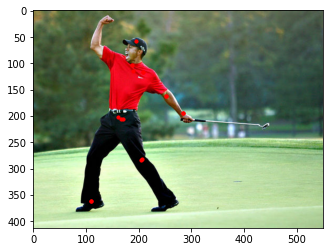

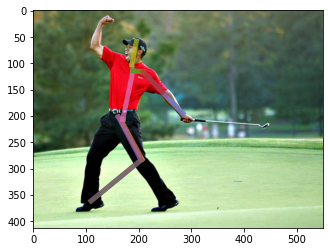

In [29]:
# 테스트 이미지를 이용해 모델의 성능을 확인
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

###  8. Project: 모델 바꿔보기

### simplebaseline 모델

In [21]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
# Encoder: Backbone: ResNet
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

In [23]:
# Decoder: Deconv Module + Upsampling
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(2,2), strides=2))
        seq_model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [24]:
upconv = _make_deconv_layer(3)
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

In [25]:
# Simplebaseline 모델 생성 함수
def Simplebaseline(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

### 학습 엔진 만들기

In [26]:
class TrainerB(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model_BL-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


In [27]:
# 데이터셋과 모델, 훈련용 객체를 조립하는 함수
# 주의할 점은 with strategy.scope():부분이 반드시 필요
# 또 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다는 것도 중요

def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

#       model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        model = Simplebaseline(IMAGE_SHAPE)

        trainer = TrainerB(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


In [30]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


INFO:tensorflow:Error reported to Coordinator: in user code:

    /tmp/ipykernel_84/3116070808.py:53 train_step  *
        loss = self.compute_loss(labels, outputs)
    /tmp/ipykernel_84/3116070808.py:44 compute_loss  *
        loss += tf.math.reduce_mean(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1383 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1700 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:464 add_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/pyt

TypeError: in user code:

    /tmp/ipykernel_84/3116070808.py:75 distributed_train_epoch  *
        per_replica_loss = self.strategy.run(
    /tmp/ipykernel_84/3116070808.py:53 train_step  *
        loss = self.compute_loss(labels, outputs)
    /tmp/ipykernel_84/3116070808.py:44 compute_loss  *
        loss += tf.math.reduce_mean(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1383 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1700 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:464 add_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:555 _apply_op_helper
        raise TypeError(

    TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type int32 of argument 'x'.


### 9. 결론 및 회고

* 휴먼포즈 에스티메이션 모델의 예측결과가 썩 좋게 나오지 않음. 생각보다 어려운 과제인 것 같음
* Hourglass 모델에 의한 결과 오른쪽 팔꿈치 및 오른쪽 무릎을 인식하지 못하는 문제 발생: 옆면의 인식률이 떨어짐
* simplebaseline 모델 내용은 맞게 한 것 같으나, 훈련과정에서 tfrecord를 처리하지 못한는 문제 발생함. 코드는 이전 기수들 및 기타 자료들을 참고했을 때 맞게 작성한 것 같음 --> 에러 내용을 자세히 보니 내부적으로 type mismatch로 나오는데 conv 내부의 어디서 생긴 오류인지 결국 찾지 못했음 --> 딥러닝에서 차원과 타입을 맞추는 작업이 중요함을 알게 되었음
* Deep Going 마지막 과제를 끝내서 홀가분하기는 하나, 아이펠톤 프로젝트가 기다리고 있음: 더욱 집중해야겠음

< reference >
* (paper) Articulated human detection with flexible mixtures-of-parts    
* (paper) DeepPose: Human Pose Estimation via Deep Neural Networks     
* https://yeomko.tistory.com/21

